# Feature-Selection

feature engineering은 모델의 성능을 향상시키는 매우 중요한 단계입니다. 그러나 feature가 너무 많으면 overfitting의 위험이 있고, 모델이 이상적인 방향으로 학습을 하지 않을 위험이 있습니다. 실제로도 feature가 너무 많은 경우 원래 모델보다 성능이 안좋게 나오는 경우가 많습니다. 따라서 feature selection을 해야 합니다.

이 커널에서는 도움이 될 만한 feature들을 모두 추가해본 뒤, feature selection 테크닉들을 통해 중요한 feature만 뽑아내는 방법을 사용하겠습니다.
<br><br>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
df3_merge = pd.read_csv('./data/df3_merge.csv')
df3_merge = df3_merge.sort_values(['sess_dt', 'hit_tm'])
df3_merge.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,latest_act_hr_1,latest_act_hr_2,latest_act_hr_3,hum,temp,pty,r06,clnt_gender,clnt_age,clac_nm2
121082,3390,1,1,0,A01,2019-07-01,00:00,0,NaN,지고트,...,-1.0,-1.0,-1.0,59.0,24.700001,0.0,0.0,NaN,NaN,NaN
194580,5535,1,1,5,A03,2019-07-01,00:00,6532,NaN,NaN,...,-1.0,-1.0,-1.0,59.0,24.700001,0.0,0.0,F,30.0,NaN
194581,5535,1,2,0,A03,2019-07-01,00:00,30494,NaN,양파,...,-1.0,-1.0,-1.0,59.0,24.700001,0.0,0.0,F,30.0,NaN
194582,5535,1,3,3,A03,2019-07-01,00:00,32370,NaN,NaN,...,-1.0,-1.0,-1.0,59.0,24.700001,0.0,0.0,F,30.0,NaN
194583,5535,1,4,0,A03,2019-07-01,00:00,41637,NaN,우엉,...,-1.0,-1.0,-1.0,59.0,24.700001,0.0,0.0,F,30.0,NaN


In [4]:
# 유저 임베딩 데이터 load
user2vec = pd.read_csv('./data/user2vec.csv')

In [5]:
df_buyer = df3_merge[df3_merge['clac_nm2'].notna()]

In [6]:
df_buyer.loc[df_buyer['pv_hr'].isnull(),'pv_hr'] = 0
df_buyer.loc[df_buyer['latest_pv_hr_1'].isnull(),'latest_pv_hr_1'] = 0
df_buyer.loc[df_buyer['latest_pv_hr_2'].isnull(),'latest_pv_hr_2'] = 0
df_buyer.loc[df_buyer['latest_pv_hr_3'].isnull(),'latest_pv_hr_3'] = 0

In [7]:
data=df_buyer.copy()

lab_len = len(df_buyer['clac_nm2'].value_counts())
label_key = df_buyer['clac_nm2'].value_counts().keys()

In [8]:
drop_col=['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'hit_tm', 'trans_id', 'sech_kwd', 'sess_dt']
df_buyer = df_buyer.drop(drop_col, axis=1)

In [9]:
CATEGORICAL_COLUMNS = [
    "biz_unit", 'trfc_src', 'dvc_ctg_nm',
    'prefer_dvc_trfc', 'clnt_gender', 'clnt_age', 'pty', 'clac_nm2'
]

In [10]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    df_buyer[c] = le.fit_transform(df_buyer[c])

In [11]:
# CONTINUOUS_COLUMNS = ['latest_pv_hr_3', 'cum_act_4', 'temp', 'cum_act_2', 'latest_act_hr_3',
#        'hour', 'hum', 'day', 'cum_act_5', 'cum_act_3', 'hit_pss_tm',
#        'cum_act_7', 'cum_act_1', 'latest_act_hr_1', 'pv_hr', 'tot_sess_hr_v',
#        'holiday', 'latest_act_hr_2', 'r06', 'cum_act_6', 'cum_act_0',
#        'latest_pv_hr_2', 'latest_pv_hr_1', 'tot_pag_view_ct']
# scaler = StandardScaler()
# df_buyer[CONTINUOUS_COLUMNS] = scaler.fit_transform(df_buyer[CONTINUOUS_COLUMNS])

In [12]:
x_data = df_buyer.drop(['clac_nm2'], axis=1)
clac_nm2 = df_buyer['clac_nm2'].copy()
y_data = df_buyer['clac_nm2']


<br><br>
## Train 데이터, Test 데이터 분할

In [13]:
train_x, test_x , train_y , test_y = train_test_split(x_data , y_data , test_size=0.05, shuffle=False)

In [14]:
print('Train 데이터: ', train_x.shape)
print('Test 데이터: ', test_x.shape)
print('Train 라벨: ', train_y.shape)
print('Test 라벨: ', test_y.shape)

Train 데이터:  (116940, 61)
Test 데이터:  (6155, 61)
Train 라벨:  (116940,)
Test 라벨:  (6155,)


In [15]:
train_x, val_x , train_y , val_y = train_test_split(train_x , train_y , test_size=0.1, shuffle=False)

In [16]:
print('Train 데이터: ', train_x.shape)
print('Val 데이터: ', val_x.shape)
print('Train 라벨: ', train_y.shape)
print('Val 라벨: ', val_y.shape)

Train 데이터:  (105246, 61)
Val 데이터:  (11694, 61)
Train 라벨:  (105246,)
Val 라벨:  (11694,)


# 도움 함수 정의

In [17]:
def top_5_accuracy(y_true, y_pred):
    score = tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)
    return  (sum(score) / len(score)).numpy()

def evaluate(x_data, y_data):
    params = {
            'n_estimators' : 10,
            'boosting_type': 'goss',
            'objective': 'multiclass',
            'num_class':288,
            'metric': 'multiclass_ova', 
            'learning_rate' : 1e-3
            }
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1, shuffle=False)

    predictors = x_train.columns.tolist()
    dtrain = lgb.Dataset(x_train.values, label=y_train, feature_name=predictors)
    dvalid = lgb.Dataset(x_val.values, label=y_val, feature_name=predictors)

    lgb_model = lgb.train(params=params,
                  train_set=dtrain,
                  early_stopping_rounds=10, # typical
                  num_boost_round=1000,
                  valid_sets=[dvalid],
                  verbose_eval=False
                 )
    preds = lgb_model.predict(x_val)
    
    
    label = y_val.copy()
    label = np.eye(1058)[label]
    score = top_5_accuracy(label, preds)
    
    del lgb_model
    return score

In [18]:
feats = [col for col in df_buyer.columns if col != 'clac_nm2']
len(feats)

61

# Baseline

In [63]:
params = {
    'n_estimators' : 1000,
    'boosting_type': 'goss',
    'objective': 'multiclass',
    'num_class':288,
    'metric': 'softmax', 
    'learning_rate' : 1e-3
    }

predictors = train_x.columns.tolist()
dtrain = lgb.Dataset(train_x.values, label=train_y, feature_name=predictors)
dvalid = lgb.Dataset(val_x.values, label=val_y, feature_name=predictors)

In [64]:
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      early_stopping_rounds=50, # typical
                      num_boost_round=1000,
                      valid_sets=[dvalid],
                      verbose_eval=False
                     )

In [65]:
prob = lgb_model.predict(test_x)

<br><br>
## 정확도 평가

In [66]:
''' 
pred_matrix: 예측된 아이템 행렬 파라미터.
top_n: 상위 몇개를 추천으로 사용할 지 정하는 파라미터.
test_matix: 고객ID와 Target이 있는 행렬 파라미터
'''
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        for j in range(len(top)):
            true_buy = [i.split("/")[0] for i in test_matix["clac_nm2"][0].split()]
            if top[j] in true_buy :
                tmp += 1

        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Hit rate of Top {}: {:>.5f}".format(top_n, avg_acc))
    return avg_acc

In [67]:
label = clac_nm2.copy()
label = np.eye(lab_len)[label]
label = pd.DataFrame(data=label, columns=label_key, index=df_buyer.index)

In [68]:
trina_y, test_y= train_test_split( label , test_size=0.05, shuffle=False)

In [69]:
test_x.loc[:,'clnt_id'] = data.loc[test_x.index, 'clnt_id']
test_x.loc[:,'trans_id'] = data.loc[test_x.index, 'trans_id']

In [70]:
# one-hot에서 같은 trans_id는 더해줌.
receipt_y = test_y.copy()
receipt_y['trans_id'] = test_x['trans_id']
frame = pd.DataFrame(data = receipt_y['trans_id'], columns=['trans_id'])
receipt_y = receipt_y.groupby('trans_id', as_index=False).sum()
receipt_y = frame.merge(receipt_y, how='left').set_index(test_x.index)
receipt_y.drop('trans_id', axis=1, inplace=True)

In [71]:
receipt_y.head()

,Frozen Instant Foods,Instant Noodles,Snacks,Domestic Fruits,Milk,Chilled Instant Foods,Tofu / Bean Sprouts,Eggs,Yogurt,Leaf Vegetables,...,Men's Special Use Clothing,Safety Equipment,Kids' General Sport Clothing,Girls' Outwear,Maternity Care Products,Inline Skates / Skate Boards / Kickboards,Improvement Supplies,Vegetable Gift Sets,Handicraft Accessories,Car Wash Equipment
116940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# 같은 영수증 별로 구매 아이템을 묶어주는 작업.
test_label = data.loc[test_x.index][['trans_id', 'clac_nm2']]
frame = pd.DataFrame(data = test_label['trans_id'], columns=['trans_id'])
test_label = test_label.groupby('trans_id', as_index=False)['clac_nm2'].apply(lambda x: ', '.join(x))
test_label = frame.merge(test_label, how='left').set_index(test_x.index)

In [73]:
test_label.head(18).tail(5)

,trans_id,clac_nm2
116953,109393.0,"Snacks, Fruit Vegetables, Dried Noodles, Froze..."
116954,109393.0,"Snacks, Fruit Vegetables, Dried Noodles, Froze..."
116955,109393.0,"Snacks, Fruit Vegetables, Dried Noodles, Froze..."
116956,109394.0,"Chilled Beverages, Leaf Vegetables, Fruit and ..."
116957,109394.0,"Chilled Beverages, Leaf Vegetables, Fruit and ..."


In [74]:
score_pd = pd.DataFrame(prob, columns=receipt_y.columns)
cond = list(np.sum(receipt_y.values, axis=1) > 10)
cond_pd = score_pd[cond].reset_index(drop= True)
test_pd = test_label[cond].reset_index(drop= True)

In [75]:
accuracy  = get_acc(cond_pd, 5 , test_pd) 

print(f"정확도: {accuracy*100}%")

Hit rate of Top 5: 0.00455
정확도: 0.4547236377891022%


In [77]:
preds = lgb_model.predict(val_x)
label = val_y.copy()
label = np.eye(288)[label]

top_5_accuracy(label, preds)

0.30896187

### 정확도 평가

In [78]:
def get_pred_list(predict_y, top_n, target_matrix):
    test_matrix = target_matrix.copy()
    pred_matrix = predict_y.copy()
    for i in range(len(pred_matrix)):
        top = pred_matrix.iloc[i].nlargest(top_n).index
        top = pd.DataFrame(top.astype(str).to_frame().apply(lambda x: ", ".join(x)))
        test_matrix.loc[i, 'pred'] = top.values[0]
    return test_matrix

In [79]:
d={'hangle': clac_nm2, 'label': data['clac_nm2']}
df = pd.DataFrame(data=d).drop_duplicates()
cate2papago = df.set_index('label').to_dict()

In [80]:
test = get_pred_list(cond_pd, 5, test_pd)

In [81]:
test

,trans_id,clac_nm2,pred
0,109400.0,"Retort Pouches, Chilled Instant Foods, Frozen ...","Body Care, Sanitary Aids, Fashion Accessories,..."
1,109400.0,"Retort Pouches, Chilled Instant Foods, Frozen ...","Body Care, Sanitary Aids, Fashion Accessories,..."
2,109400.0,"Retort Pouches, Chilled Instant Foods, Frozen ...","Body Care, Sanitary Aids, Fashion Accessories,..."
3,109400.0,"Retort Pouches, Chilled Instant Foods, Frozen ...","Body Care, Sanitary Aids, Fashion Accessories,..."
4,109400.0,"Retort Pouches, Chilled Instant Foods, Frozen ...","Body Care, Sanitary Aids, Fashion Accessories,..."
...,...,...,...
2546,112614.0,"Domestic Porks, Frozen Instant Foods, Sauces, ...","Body Care, Decorative Accessories, Sanitary Ai..."
2547,112614.0,"Domestic Porks, Frozen Instant Foods, Sauces, ...","Body Care, Decorative Accessories, Sanitary Ai..."
2548,112614.0,"Domestic Porks, Frozen Instant Foods, Sauces, ...","Body Care, Decorative Accessories, Sanitary Ai..."
2549,112614.0,"Domestic Porks, Frozen Instant Foods, Sauces, ...","Body Care, Decorative Accessories, Sanitary Ai..."


# Basic Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

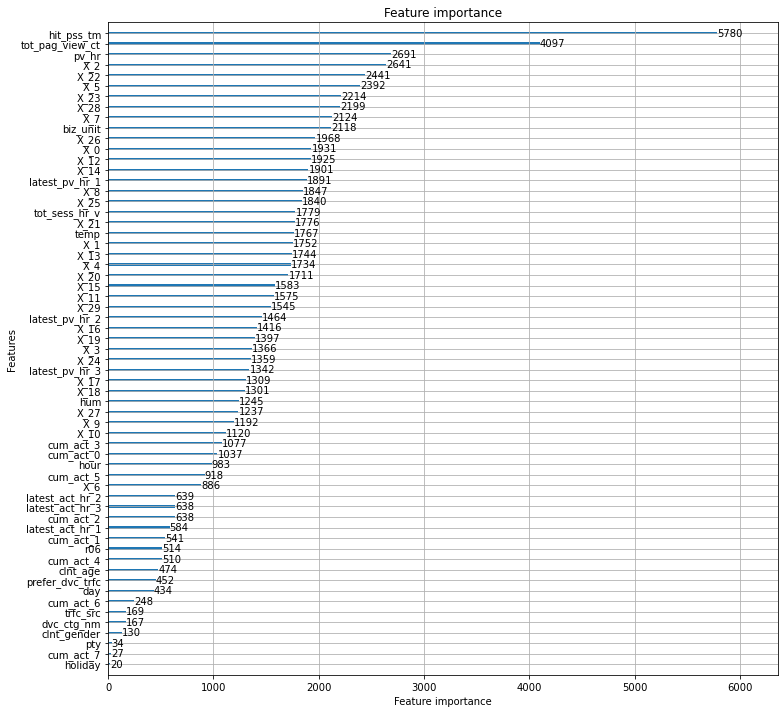

In [43]:
lgb.plot_importance(lgb_model, figsize = (12, 12))

In [46]:
lgb_model.feature_importance()

array([2118, 5780, 4097, 1779,  169,  167, 1037,  541,  638, 1077,  510,
        918,  248,   27,  434,   20,  983, 2691, 1891, 1464, 1342,  452,
        584,  639,  638, 1245, 1767,   34,  514,  130,  474, 1931, 1752,
       2641, 1366, 1734, 2392,  886, 2124, 1847, 1192, 1120, 1575, 1925,
       1744, 1901, 1583, 1416, 1309, 1301, 1397, 1711, 1776, 2441, 2214,
       1359, 1840, 1968, 1237, 2199, 1545], dtype=int32)

### 2. One-shot

In [84]:
feat_imp

hit_pss_tm         5780
tot_pag_view_ct    4097
pv_hr              2691
X_2                2641
X_22               2441
                   ... 
dvc_ctg_nm          167
clnt_gender         130
pty                  34
cum_act_7            27
holiday              20
Length: 61, dtype: int32

In [83]:
feat_imp = pd.Series(lgb_model.feature_importance(), index=feats).sort_values(ascending=False)
for i in range(0, 61, 1):
    temp = feat_imp.index.to_list()
    del temp[i]
    print(i, evaluate(df_buyer[temp], df_buyer['clac_nm2']))

0 0.23533712
1 0.23533712
2 0.23533712
3 0.23533712


KeyboardInterrupt: 